<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/lesson_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
df_school_master = pd.read_csv(os.path.join(DIR_NAME, 'private_school_master.csv'))
print(df_school_master.shape)

(7307, 6)


In [6]:
df_school_master['施設分類'].value_counts()

学習塾        2306
保育園        2093
小学校         694
幼稚園         449
音楽教室        426
中学校         319
幼児教室        286
高等学校        212
大学          177
英語教室        111
プログラミング      91
学童保育         50
専門学校         39
囲碁将棋         31
ダンス          23
Name: 施設分類, dtype: int64

In [11]:
lesson_type = ['音楽教室', '英語教室', 'プログラミング', '囲碁将棋']

In [16]:
df_lesson_master = df_school_master[df_school_master['施設分類'].isin(lesson_type)].reset_index(drop=True)
print(df_lesson_master.shape)

(659, 6)


In [17]:
df_lesson_master.head()

,名称,住所,緯度,経度,施設分類,rating
0,QUREO(キュレオ)プログラミング教室 iTeen 世田谷上野毛校,世田谷区中町４丁目２７−１,35.618609,139.642497,プログラミング,NaN
1,QUREO(キュレオ)プログラミング教室 YBA教育研究会,世田谷区宮坂１丁目４６−１１,35.650619,139.640233,プログラミング,NaN
2,QUREO(キュレオ)プログラミング教室 明光義塾 成城学園教室,世田谷区成城６丁目１６−６,35.640786,139.597107,プログラミング,NaN
3,QUREO(キュレオ)プログラミング教室 明光義塾 桜新町教室,世田谷区桜新町１丁目１４−２３ Futami 萬豊ビル 2F,35.630255,139.643746,プログラミング,NaN
4,QUREO(キュレオ)プログラミング教室 城南コベッツ 祖師ヶ谷大蔵駅前教室,世田谷区砧６丁目３０−４ ＹＭビル 2F,35.641544,139.608452,プログラミング,NaN


### 地理マスタ

In [14]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [15]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            pass # print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [18]:
%%time
for lesson in lesson_type:
    radius = 0.5
    # 0.5km以内の施設の数
    df_geo_master[f'{lesson}(数)'] = get_value_of_nearest_facility(df_geo_master, df_lesson_master, lesson, 'count', radius)

CPU times: user 27 s, sys: 335 ms, total: 27.3 s
Wall time: 27 s


In [19]:
for lesson in lesson_type:
    df_geo_master[f'{lesson}(数)'] = df_geo_master[f'{lesson}(数)'].fillna(0).astype(int)

In [21]:
df_geo_master.head()

,town_id,市区町村名,町名,町丁目,緯度,経度,音楽教室(数),英語教室(数),プログラミング(数),囲碁将棋(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0,0,0,0
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0,0,0,0
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0,0,0,0
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0,2,0,0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0,2,0,0


In [22]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]

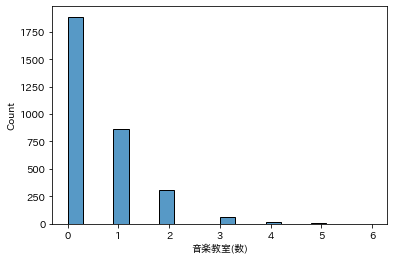

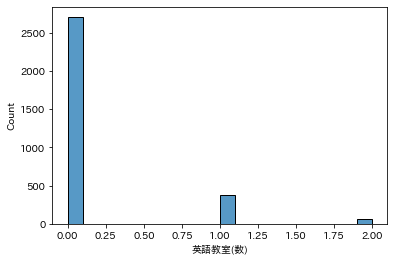

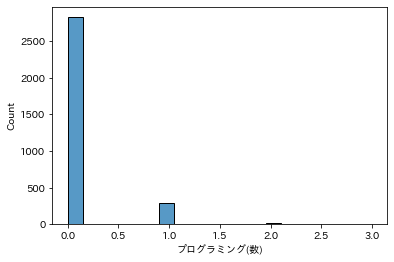

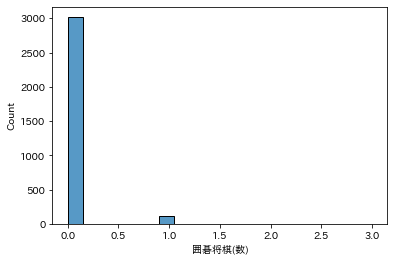

In [24]:
for feature in feature_list:
    sns.histplot(df_geo_master[feature], bins=20)
    plt.show()

In [25]:
df_geo_master[['town_id'] + feature_list].to_csv(os.path.join(DIR_NAME, 'lesson_score.csv'), index=False, encoding='utf-8_sig')